In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [2]:
text = ''
for i in ['tom_1.txt','tom_2.txt','tom_3.txt','tom_4.txt']:
    with open(i, 'r', encoding="utf-8") as f:
        part = f.read().lower()
    part = re.sub('[^а-я]','', part)
    text += part

In [3]:
text[:100]

'левтолстойвойнаимиртомтомчастьперваячастьораячастьтретьятомлевниколаевичтолстойвойнаимиртомчастьперв'

In [4]:
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьъэюя'
POS = {l: i for i, l in enumerate(RUSSIAN)}

In [5]:
POS

{'а': 0,
 'б': 1,
 'в': 2,
 'г': 3,
 'д': 4,
 'е': 5,
 'ё': 6,
 'ж': 7,
 'з': 8,
 'и': 9,
 'й': 10,
 'к': 11,
 'л': 12,
 'м': 13,
 'н': 14,
 'о': 15,
 'п': 16,
 'р': 17,
 'с': 18,
 'т': 19,
 'у': 20,
 'ф': 21,
 'х': 22,
 'ц': 23,
 'ч': 24,
 'ш': 25,
 'щ': 26,
 'ъ': 30,
 'ы': 28,
 'ь': 29,
 'э': 31,
 'ю': 32,
 'я': 33}

In [6]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [7]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [8]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

<ipython-input-8-dc1e1f362eff>:1: RuntimeWarning: invalid value encountered in true_divide
  probabilities = (probabilities / probabilities.sum(axis=1)[:, None])


In [9]:
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

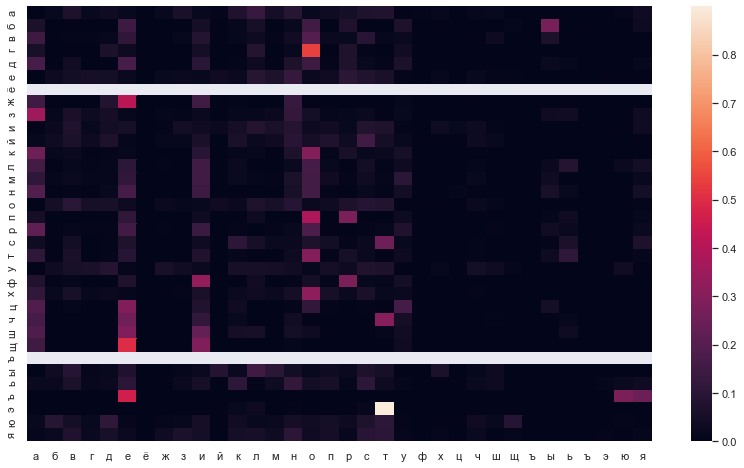

In [10]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

In [17]:
res = []
start = POS['п']
end = POS['р']
prior = 1. / len(RUSSIAN)
for c in RUSSIAN:
    proba = prior * probabilities[start, POS[c]]
    if proba > 0:
            for s in RUSSIAN:
                proba2 = proba *  probabilities[POS[c], POS[s]] * probabilities[POS[s], end]
                if proba2 > 0:
                    res.append(proba2)
print('Вероятность встретить слово из 4 букв, с началом на п и окончанием на Р равна ', sum(res))

Вероятность встретить слово из 4 букв, с началом на п и окончанием на Р равна  0.0012554603284365975


In [53]:
s = []
start = 'б'
s.append(start)
length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бывасиерь


# Модели временных рядов с переключениями

In [18]:
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
s = np.random.binomial(n=1, p=0.8, size=100)
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps

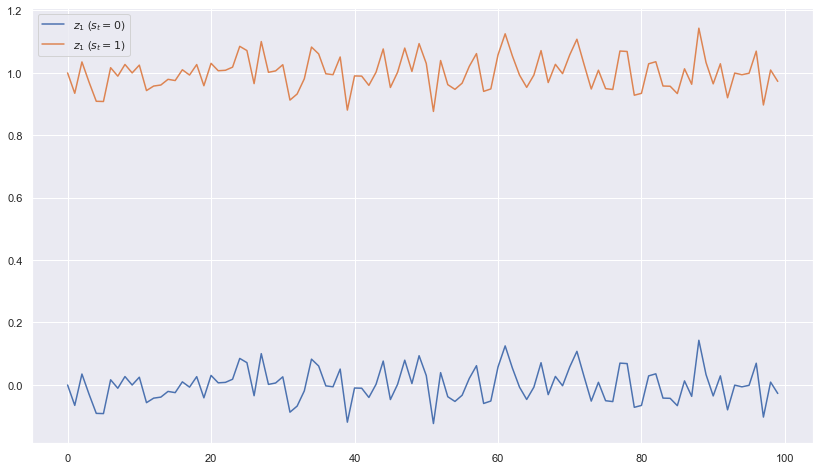

In [19]:
plt.figure(figsize=(14,8))
plt.plot(z1, label='$z_1$ ($s_t = 0$)')
plt.plot(z2, label='$z_1$ ($s_t = 1$)')
plt.legend()
plt.show()

In [18]:
z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

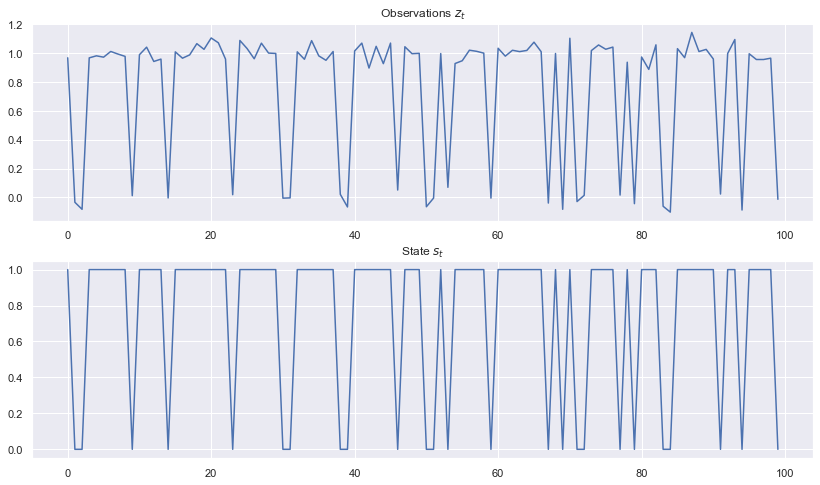

In [19]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Это стационарный AR(1) процесс со средним $\dfrac{\alpha_0}{1-\beta}$ при $s_t=0$ и переключающийся на другой стационарный AR(1) процесс со средним $\dfrac{\alpha_0+\alpha_1}{1-\beta}$, когда $s_t$ переключается с 0 на 1.

- если $a_1 \ne 0$: два динамических паттерна в зависимости от значения переменной состояния $s_t$;
- в этом случае $z_t$ управляется двумя распределениями с разным средним;
- переменная $s_t$ отвечает за переключение между этими распределениями (режимами).

Только что показанный пример: $s_t \sim Bern(p),p=0.8$.

В этой модели $s_t$ не зависит от предыдущих и будущих реализаций, поэтому $z_t$ может сильно "прыгать" (часто переключаться между разными состояниями).

### Практика. Сгенерируйте модель с переключениями на основе двух моделей AR(1)

## Что такое модель с марковским переключением?

Пусть, как раньше,

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1 согласно марковской цепи первого порядка:

$P=\begin{pmatrix} P(s_t=0|s_{t-1}=0) & P(s_t=1|s_{t-1}=0 \\ P(s_t=0|s_{t-1}=1) & P(s_t=1|s_{t-1}=1 \end{pmatrix} = \begin{pmatrix} p_{00} & p_{01} \\ p_{10} & p_{11} \end{pmatrix}$

где за $p_{ij},i,j∈\{0,1\}$ обозначена вероятность перехода в состояние $s_t=j$ из состояния $s_{i−1}=i$.

- Матрица перехода управляет случайным поведением переменной состояния и зависит только от двух параметров ($p00$
 и $p11$).
- Модель такого типа называют моделью с марковскими переключениями.
- Свойства $z_t$ определяются характеристиками распределения как $\epsilon_t$, так и переменной состояния $s_t$.
- В частности, марковская переменная состояния приводит к случайным и частым сменам режима, а вероятности перехода определяют персистентность каждого из режимов.

Важный факт: распределение наблюдений обусловлено ненаблюдаемой переменной состояния:
$Law(z_t)=Law(z_t|s_t)$

Например:
- $Law(z_t|s_t=0) = N(\dfrac{\alpha_0}{1-\beta}, \sigma_\epsilon^2)$
- $Law(z_t|s_t=1) = N(\dfrac{\alpha_0 + \alpha_1}{1-\beta}, \sigma_\epsilon^2)$

# Прогноз с использованием HMM

In [29]:
from hmmlearn.hmm import GaussianHMM

In [30]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")["Close"]

In [31]:
values = series.values.reshape(-1,1)

In [32]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -894.2620483582108
2 -820.6341453620573
3 -786.8375332667716
4 -752.0201472668953
5 -737.1181532202377
6 -729.567111258944
7 -713.7233636558291
8 -702.1057754508208
9 -690.9838068209682
10 -684.6738312870401


Fitting a model with 167 free scalar parameters with only 162 data points will result in a degenerate solution.


11 -682.0094696781595


Fitting a model with 194 free scalar parameters with only 162 data points will result in a degenerate solution.


12 -675.2670827551527
13 -655.291948599901


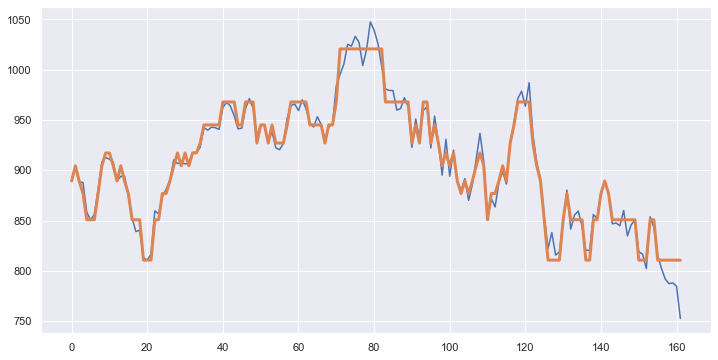

In [33]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)